In [11]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# select network
TOPAZ = ("topaz","f071c66c")
SCHLESI = ("schlesi","9925efd6")
NETWORK,FORK_DIGEST=TOPAZ

# run crawler
#!sh crawl-network.sh $NETWORK 50 snapshot

# A (DHT) Crawl Through The Topaz Testnet 🕷

#### by [Jonny Rhea](https://twitter.com/JonnyRhea) of [TXRX Research](https://twitter.com/TXRXResearch)

In [12]:
import pandas as pd 

dfs = []
start = 12000
numFiles = !ls -l ~/.$NETWORK/crawler* |wc -l
numFiles = int(numFiles[0].strip())
end = start + numFiles
for port in list(range(start,end)):
    file="~/."+NETWORK+"/crawler"+str(port)+".csv"
    df = pd.read_csv(file) 
    df.drop(columns=['index'])
    dfs.append(df)
df_all_with_dups = pd.concat(dfs).reset_index(drop=True).sort_values(by=['seq_no'], ascending=False) #ensure we keep highest seq no
df_all = df_all_with_dups.drop_duplicates(subset="node_id", keep = 'first').reset_index(drop=True)
df_all.set_index('node_id')
df = df_all[df_all['fork_digest']==FORK_DIGEST]
tot_num_nodes = len(df_all)
num_nodes = len(df)
#tot_num_nodes, num_nodes

### 🕸 Crawl Summary 🕸

- **Total number of nodes found:** {{ tot_num_nodes }}
- **Number of nodes on Topaz:** {{ num_nodes }}

In [13]:
%%capture
import ipinfo
import pickle

ips = df["ip4"].to_list()

# load any stored ip info
file = open('/Users/jonny/.topaz/ips_info.pkl', 'rb')
saved_ips_info = pickle.load(file)
file.close()

# determine what ips we need to lookup
need_info = []
for ip in ips:
    if ip not in saved_ips_info:
        need_info.append(ip)
        
print("Fetching missing info for ", len(need_info), " ip addresses.");
        
# get missing ip info
handler = ipinfo.getHandler('7bbf8b616179fb')
ips_info = [handler.getDetails(ip) for ip in need_info]

# save the ip info for next time

file = open('/Users/jonny/.topaz/ips_info.pkl', 'wb')

for ip_info in ips_info:
    saved_ips_info[ip_info.ip] = ip_info.all

pickle.dump(saved_ips_info,file)
file.close()

ips_info={}
for ip in ips:
    ips_info[ip]=saved_ips_info[ip]
    
    
#WHOIS
# whois -h whois.cymru.com " -v 62.210.170.177"
#  whois -h whois.arin.net 159.65.217.119
# whois -h whois.ripe.net 62.210.170.177
bad_ips = []
for ip,info in ips_info.items():
    if info['country_name'] == None:
        bad_ips.append(ip)

# collect node_ids of the records with bad ip addresses
bad_ip_node_ids = df[df['ip4'].isin(bad_ips)]['node_id'].to_list()

asn_orgs = [info['org'] if 'org' in info else 'None' for ip,info in ips_info.items()]
asn_orgs = [' '.join(org.split(' ')[1:]) for org in asn_orgs if org != 'None']


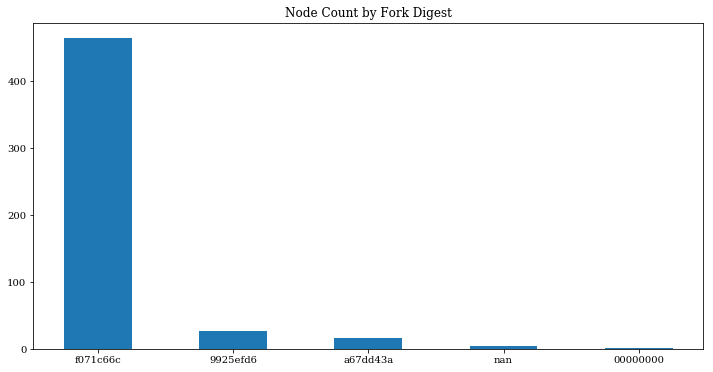

In [14]:
from collections import Counter 
import numpy as np
import matplotlib.pyplot as plt


fork_digests = df_all["fork_digest"].to_list()

counts = Counter(fork_digests)
counts = sorted(counts.items(), key=lambda i: i[1], reverse=True)
labels, values  = zip(*counts)

indexes = np.arange(len(labels))
width = .5
plt.rc('font', family='serif')
plt.figure(figsize=(12,6))
plt.title('Node Count by Fork Digest')
plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.show()

> #### Only nodes with fork-digest `f071c66c` are members of the Topaz network.  Fun fact, all eth2 testnets and mainnet will share a DHT for **security**.  There is currently an issue open in the eth2 repo discussing [this topic](https://github.com/ethereum/eth2.0-specs/issues/1770) - join the discussion if you have some insight to share.

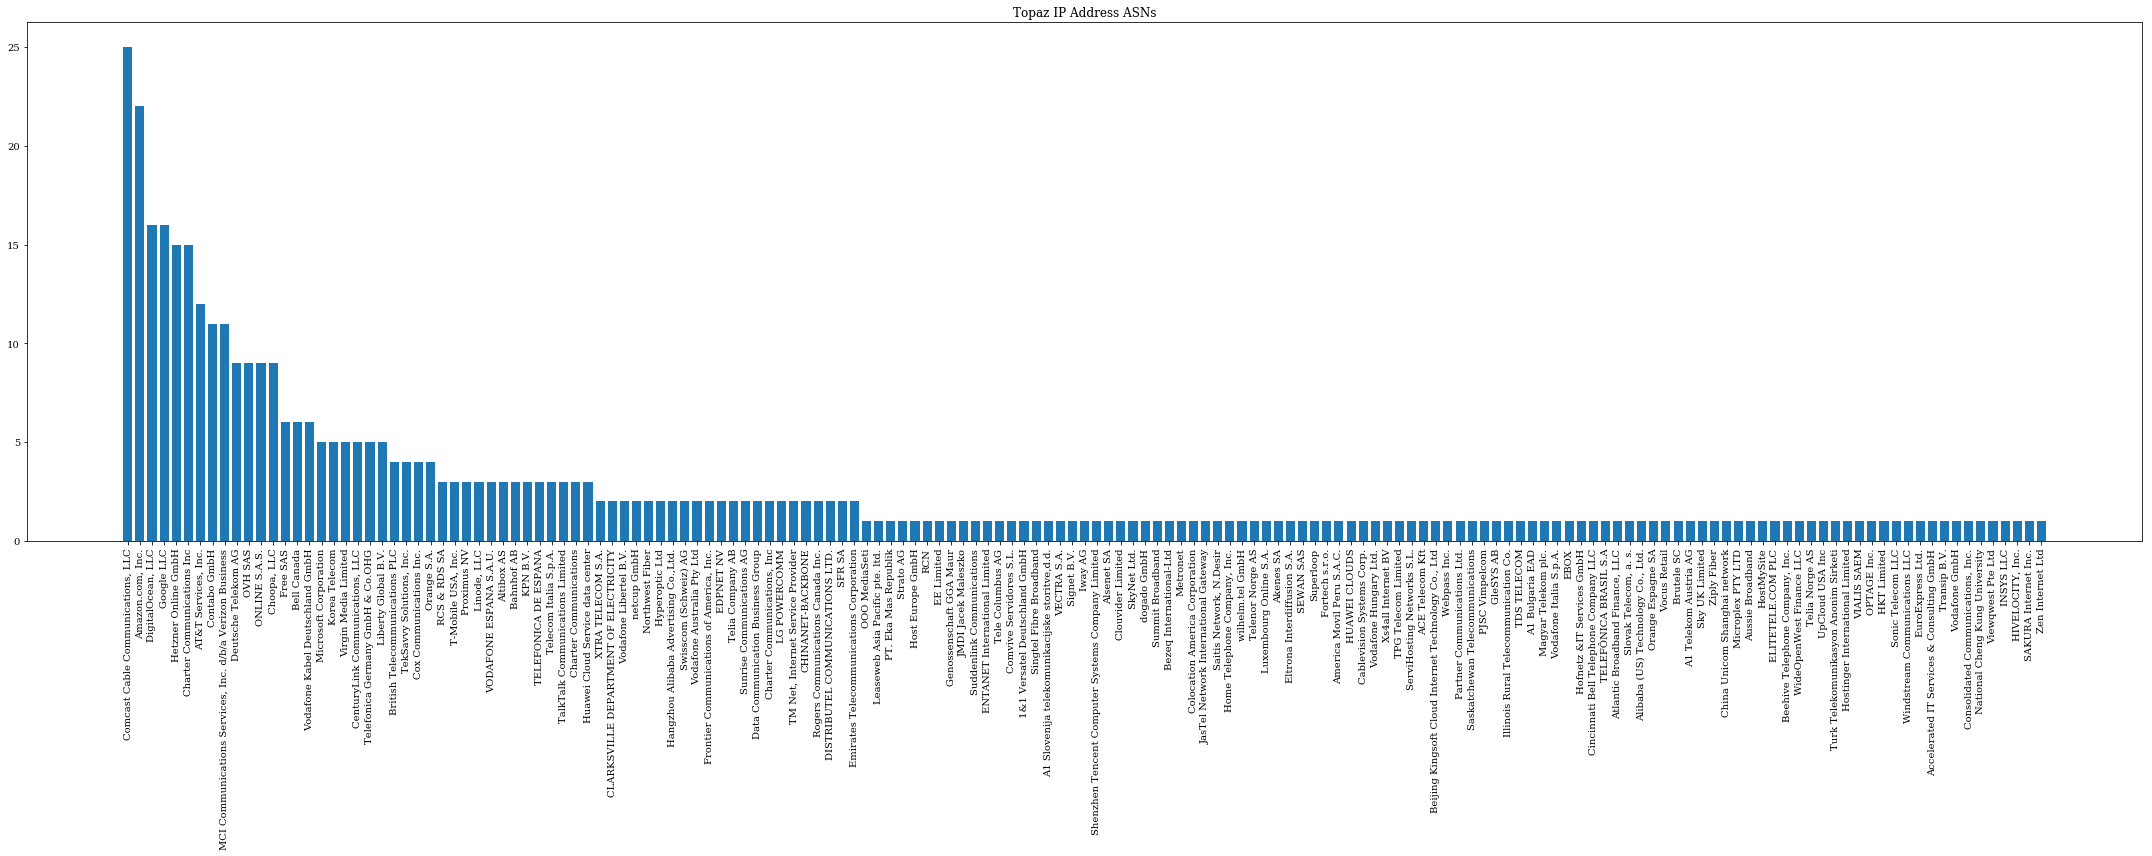

In [15]:
from collections import Counter 
import numpy as np
import matplotlib.pyplot as plt

counts = Counter(asn_orgs)
counts = sorted(counts.items(), key=lambda i: i[1], reverse=True)
labels, values  = zip(*counts)

indexes = np.arange(len(labels))
width = .75
plt.rc('font', family='serif')
plt.figure(figsize=(30,12))
plt.title(NETWORK.title()+' IP Address ASNs')
plt.bar(indexes, values, width)
plt.xticks(rotation=90)
plt.xticks(indexes, labels)
plt.tight_layout()
plt.show()


### 🕸 Node Distribution 🕸

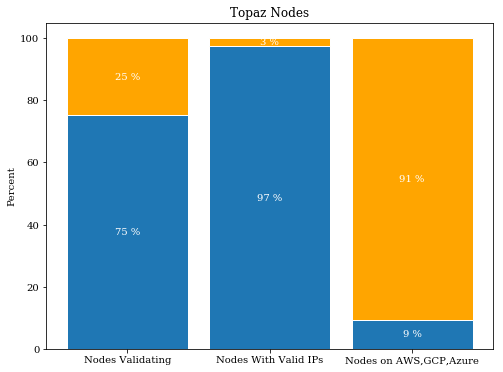

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from collections import Counter 

NUM_NODES = len(df)
df_nodes_with_bad_ip = df_all_with_dups[df_all_with_dups['node_id'].isin(bad_ip_node_ids)].drop_duplicates(subset="node_id", keep = 'first')
PERCENT_WITH_BAD_IP = len(df_nodes_with_bad_ip[df_nodes_with_bad_ip['fork_digest']==FORK_DIGEST])/NUM_NODES
PERCENT_VALIDATING = len(df[df["subnet_ids"]!="[]"])/NUM_NODES
num_nodes_cloud_hosted = 0
for org in asn_orgs:
    if "Amazon"  in org or "Google" in org or "Microsoft" in org:
        num_nodes_cloud_hosted += 1
    
PERCENT_CLOUD_HOSTED=num_nodes_cloud_hosted/NUM_NODES



# Data
r = [0,1,2]
raw_data = {'blueBars': [PERCENT_VALIDATING,1-PERCENT_WITH_BAD_IP,PERCENT_CLOUD_HOSTED], 'orangeBars': [1-PERCENT_VALIDATING,PERCENT_WITH_BAD_IP,1-PERCENT_CLOUD_HOSTED]}
df_nodes = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j for i,j in zip(df_nodes['blueBars'], df_nodes['orangeBars'])]
blueBars = [i / j * 100 for i,j in zip(df_nodes['blueBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df_nodes['orangeBars'], totals)]
 
# plot
barWidth = 0.85
names = ('Nodes Validating','Nodes With Valid IPs','Nodes on AWS,GCP,Azure')
fig,ax = plt.subplots(figsize=(8,6))
ax.bar(r, blueBars, color='#1f77b4', edgecolor='white', width=barWidth)
ax.bar(r, orangeBars, bottom=blueBars, color='orange', edgecolor='white', width=barWidth)
ax.set_ylabel('Percent')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f} %'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white')

plt.title(NETWORK.title()+' Nodes')
# Custom x axis
plt.xticks(r, names)
plt.rc('font', family='serif')
# Show graphic
plt.show()


> - **Nodes Validating:** If a node's ENR indicated that it belonged to one or more persistent committees, then it was considered a validating node.
- **Nodes with Valid IPs:** IP address within one of the private IPv4 network ranges were considered invalid.
- **Nodes on AWS, GCP, Azure:** IP addresses that corresponded to an ASN that belongs to Amazon, Google, or Microsoft.

### 🕸 Subnet Distribution 🕸

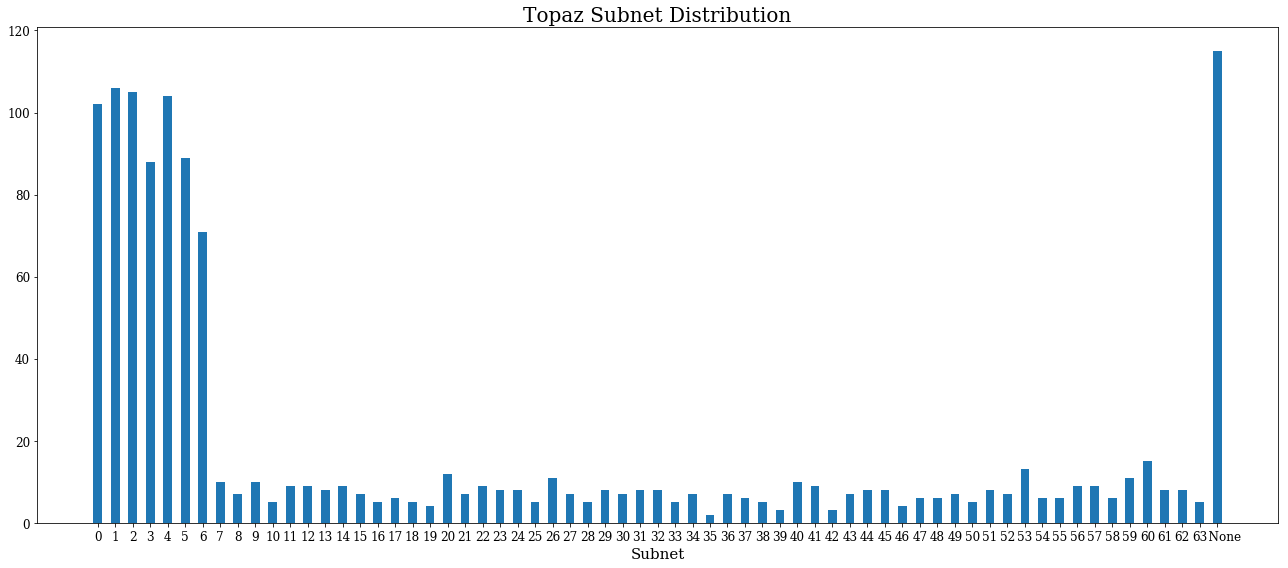

In [17]:
import numpy as np
import matplotlib.pyplot as plt

subnets = df["subnet_ids"].to_list()
subnets = [subnet.replace('[','').replace(']','').replace(' ','') for subnet in subnets]
subnets = [subnet if len(subnet) > 0 else '    None' for subnet in subnets]
subnets = ','.join(subnets)
subnets = subnets.split(',')
labels = [str(label) for label in list(range(0,64))] + ['    None']
values = [subnets.count(label) for label in labels]

indexes = np.arange(len(labels))
width = .5
plt.figure(figsize=(18,8))
plt.title(NETWORK.title()+' Subnet Distribution',fontsize=20)
plt.bar(indexes, values, width)
plt.yticks(fontsize=12)
plt.xticks(indexes, labels,fontsize=12)
plt.xlabel("Subnet",fontsize=15)
plt.rc('font', family='serif')
plt.tight_layout()
plt.show()

> #### Subnet subscriptions should be evenly distributed from `0 - 63`.  A recent commit to Prysm fixes this so .... update your nodes?  Fyi, nodes that aren't hosting a validator aren't subscribed to any subnets and are categorized as `None`

### 🕸 Node Locations 🕸

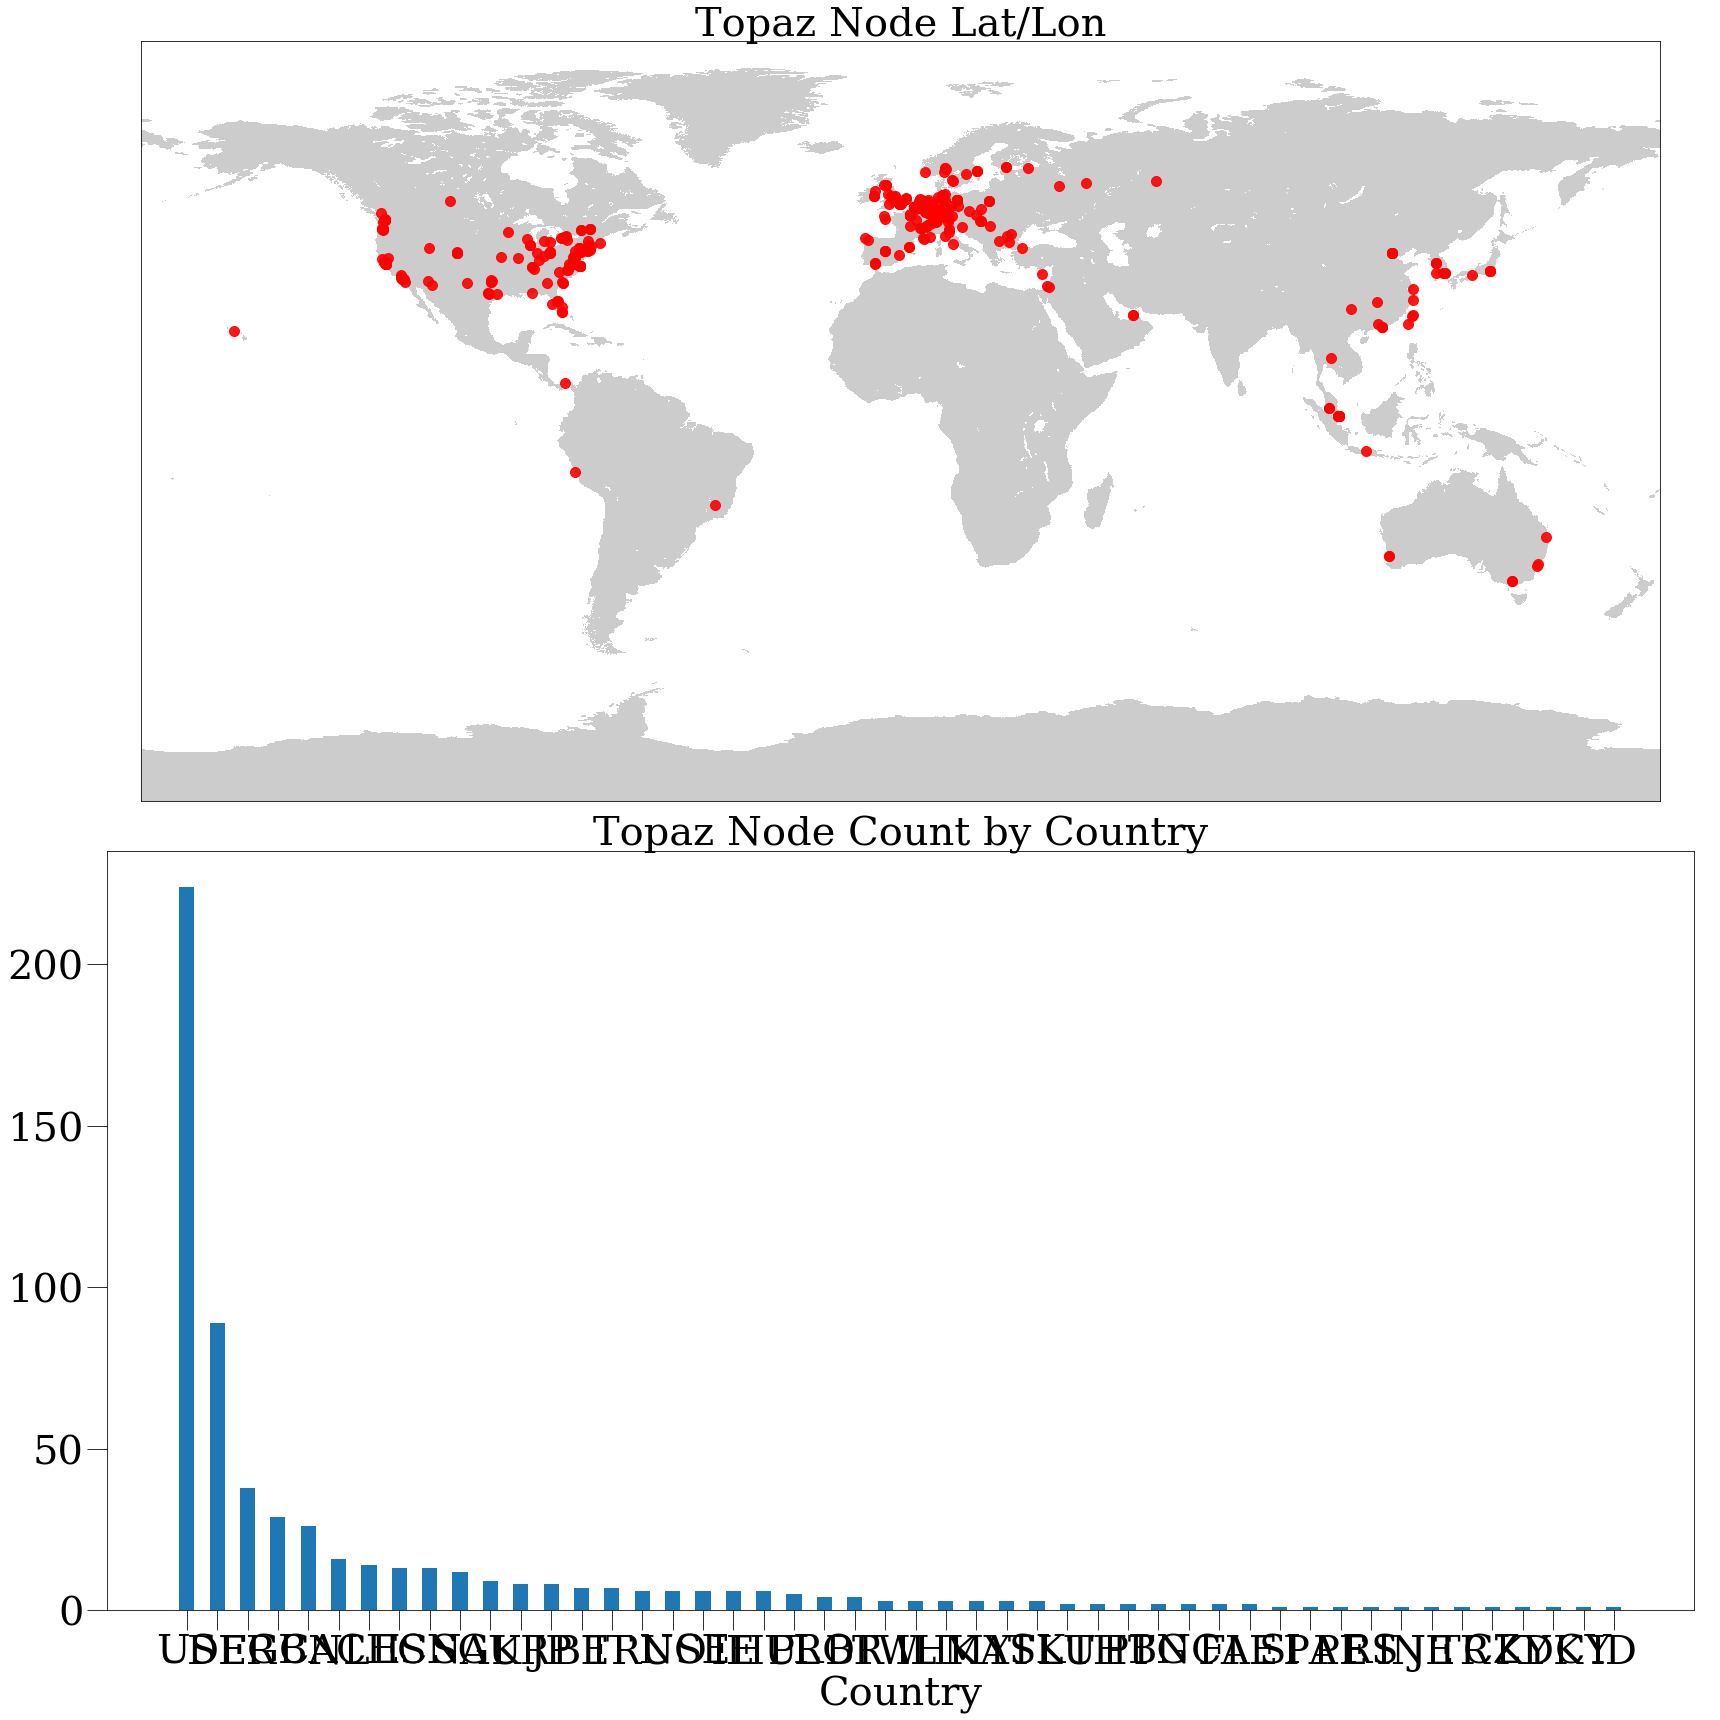

In [26]:
import os
os.environ['PROJ_LIB'] = '/Users/jonny/opt/anaconda3/share/proj'
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from collections import Counter 
import numpy as np

# plot nodes on map
lats=[]
lons=[]
for ip,info in ips_info.items():
    if info['country_name'] != None:
        lats.append(float(info['latitude']))
        lons.append(float(info['longitude']))

fig,ax = plt.subplots(2,figsize=(24,24))
map = Basemap(projection='cyl', resolution='l',ax=ax[0])
map.drawlsmask()
x, y = map(lons, lats)
map.scatter(x, y, s=100, color='#ff0000', marker='o', alpha=0.9)
ax[0].set_title(NETWORK.title()+' Node Lat/Lon',fontsize=40)

#plot node count by country
countries=[]
for ip,info in saved_ips_info.items():
    if info['country_name'] != None:
        countries.append(info['country'])


counts = Counter(countries)
counts = sorted(counts.items(), key=lambda i: i[1], reverse=True)
labels, values  = zip(*counts)

indexes = np.arange(len(labels))
width = .5

ax[1].set_title(NETWORK.title()+' Node Count by Country',fontsize=40)
ax[1].bar(indexes, values, width)
ax[1].set_xticks(indexes)
ax[1].set_xticklabels(labels)
ax[1].set_xlabel("Country",fontsize=40)
ax[1].tick_params(size=20,labelsize=40)
plt.rc('font', family='serif')
plt.tight_layout()
plt.show()

> #### Node location information is gathered by geolocating ip addresses 🌍

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter 
node_ids = df["node_id"].to_list()
node_ids = [node_id.strip() for node_id in node_ids]
node_ids_freq = [Counter(node_id) for node_id in node_ids]
hex_chars = ['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f']
freqs = []
for node_id_freq in node_ids_freq:
    freqs.append([node_id_freq[hex_char] for hex_char in hex_chars])

x, y = np.meshgrid(hex_chars, node_ids)
intensity = np.array(freqs)

#plt.title(NETWORK.title()+' NodeId Character Heatmap',fontsize=40)
#plt.pcolormesh(x, y, intensity)
#plt.colorbar()
#plt.rc('font', family='serif')
#plt.xticks(fontsize=40)
#plt.rcParams["figure.figsize"] = (50,50)
#plt.tight_layout()
#plt.show()

In [20]:
#df_all[df_all["ip6"].notnull()]